In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

# Data Loading and Cleaning

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
data_set=tf.keras.preprocessing.image_dataset_from_directory(
"potato_file",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [4]:
data_set.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
class_names = data_set.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch,labels_batch in data_set.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 0 0 0 2 1 1 0 1 0 0 0 2 1 1 2 0 0 0 0 0 1 1 0 1 1 0 1]


In [7]:
#data visualization

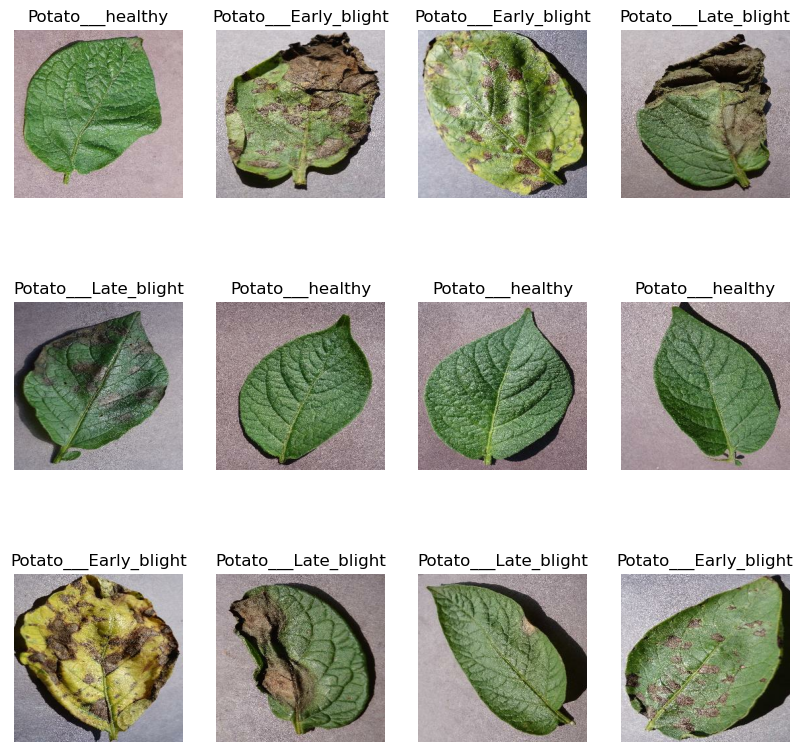

In [8]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in data_set.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("Off")

In [9]:
#diving the dataset into training and testing dataset
#80% = training
#10% = validation
#10% = test

In [10]:
train_size = 0.8
len(data_set)*train_size

54.400000000000006

In [11]:
trainig_ds = data_set.take(54)
len(trainig_ds)

54

In [12]:
test_ds = data_set.skip(54)
print(test_ds)
len(test_ds)

<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


14

In [13]:
val_ds = 0.1
len(data_set)*val_ds

6.800000000000001

In [14]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_split + val_split) == 1
    ds_size = ds.cardinality().numpy()  # Get the total size of the dataset

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Optionally shuffle the datasets
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
        
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)

        
    return train_ds, val_ds, test_ds    


In [17]:
train_ds , val_ds ,test_ds = get_dataset_partitions_tf(data_set)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
#normalize 
for image_batch , labels_batch in data_set.take(1):
    print(image_batch[0].numpy()/255)

[[[0.7490196  0.7529412  0.8235294 ]
  [0.7294118  0.73333335 0.8039216 ]
  [0.69803923 0.7019608  0.77254903]
  ...
  [0.4627451  0.45490196 0.50980395]
  [0.53333336 0.5254902  0.5803922 ]
  [0.4745098  0.46666667 0.52156866]]

 [[0.7254902  0.7294118  0.8       ]
  [0.7137255  0.7176471  0.7882353 ]
  [0.7019608  0.7058824  0.7764706 ]
  ...
  [0.59607846 0.5882353  0.6431373 ]
  [0.54509807 0.5372549  0.5921569 ]
  [0.4627451  0.45490196 0.50980395]]

 [[0.7137255  0.7176471  0.7882353 ]
  [0.7137255  0.7176471  0.7882353 ]
  [0.7176471  0.72156864 0.7921569 ]
  ...
  [0.6627451  0.654902   0.70980394]
  [0.68235296 0.6745098  0.7294118 ]
  [0.67058825 0.6627451  0.7176471 ]]

 ...

 [[0.62352943 0.6156863  0.6666667 ]
  [0.61960787 0.6117647  0.6627451 ]
  [0.627451   0.61960787 0.67058825]
  ...
  [0.6117647  0.6117647  0.65882355]
  [0.6039216  0.6039216  0.6509804 ]
  [0.5764706  0.5764706  0.62352943]]

 [[0.6431373  0.63529414 0.6862745 ]
  [0.62352943 0.6156863  0.6666667 ]


In [23]:
#resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

In [24]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
]
)

# model building

In [25]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model =models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])



In [26]:
model.build(input_shape = input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [28]:
#compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
             )

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/30
54/54 [==============================] - 93s 2s/step - loss: 0.8696 - accuracy: 0.5191 - val_loss: 0.7800 - val_accuracy: 0.6198
Epoch 2/30
54/54 [==============================] - 127s 2s/step - loss: 0.6735 - accuracy: 0.6782 - val_loss: 0.5278 - val_accuracy: 0.7656
Epoch 3/30
54/54 [==============================] - 118s 2s/step - loss: 0.5024 - accuracy: 0.7847 - val_loss: 0.5395 - val_accuracy: 0.7812
Epoch 4/30
54/54 [==============================] - 102s 2s/step - loss: 0.4126 - accuracy: 0.8316 - val_loss: 0.4496 - val_accuracy: 0.7604
Epoch 5/30
54/54 [==============================] - 95s 2s/step - loss: 0.3068 - accuracy: 0.8802 - val_loss: 0.3013 - val_accuracy: 0.8750
Epoch 6/30
54/54 [==============================] - 95s 2s/step - loss: 0.2691 - accuracy: 0.8953 - val_loss: 0.2520 - val_accuracy: 0.8906
Epoch 7/30
54/54 [==============================] - 97s 2s/step - loss: 0.2344 - accuracy: 0.9144 - val_loss: 0.2753 - val_accuracy: 0.8542
Epoch 8/30
54/54 

In [30]:
len(test_ds)

8

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 362ms/step - loss: 0.1040 - accuracy: 0.9648


In [32]:
scores

[0.10399152338504791, 0.96484375]

In [33]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
len(history.history['loss'])

30

In [38]:
len(history.history['accuracy'])

30

In [39]:
len(history.history['val_loss'])

30

In [40]:
len(history.history['val_accuracy'])

30

In [41]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

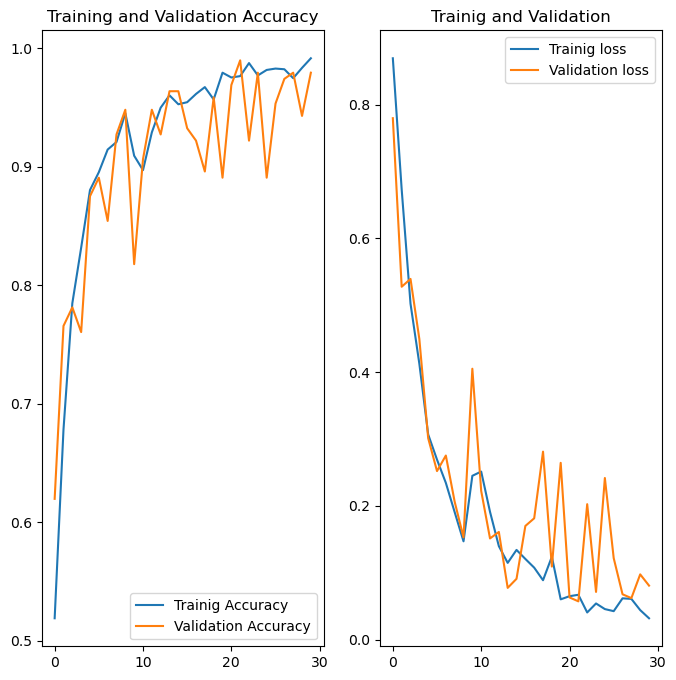

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Trainig Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Trainig loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc="upper right")
plt.title("Trainig and Validation")
plt.show()

First image to predict
Actual label : Potato___Late_blight
1/1 [==============================] - 0s 404ms/step
Prediction Label: Potato___Late_blight


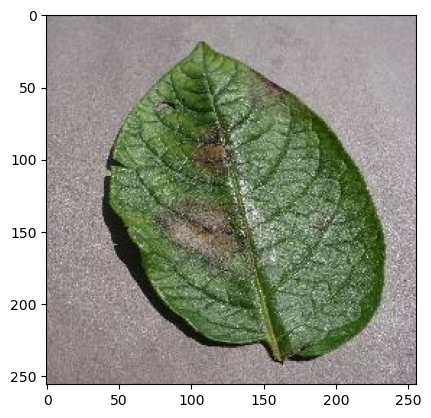

In [71]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label :",class_names[labels_batch[0].numpy()])
    
    batch_prediction = model.predict(image_batch)
    print("Prediction Label:",class_names[np.argmax(batch_prediction[0])])
    

In [75]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 34ms/step


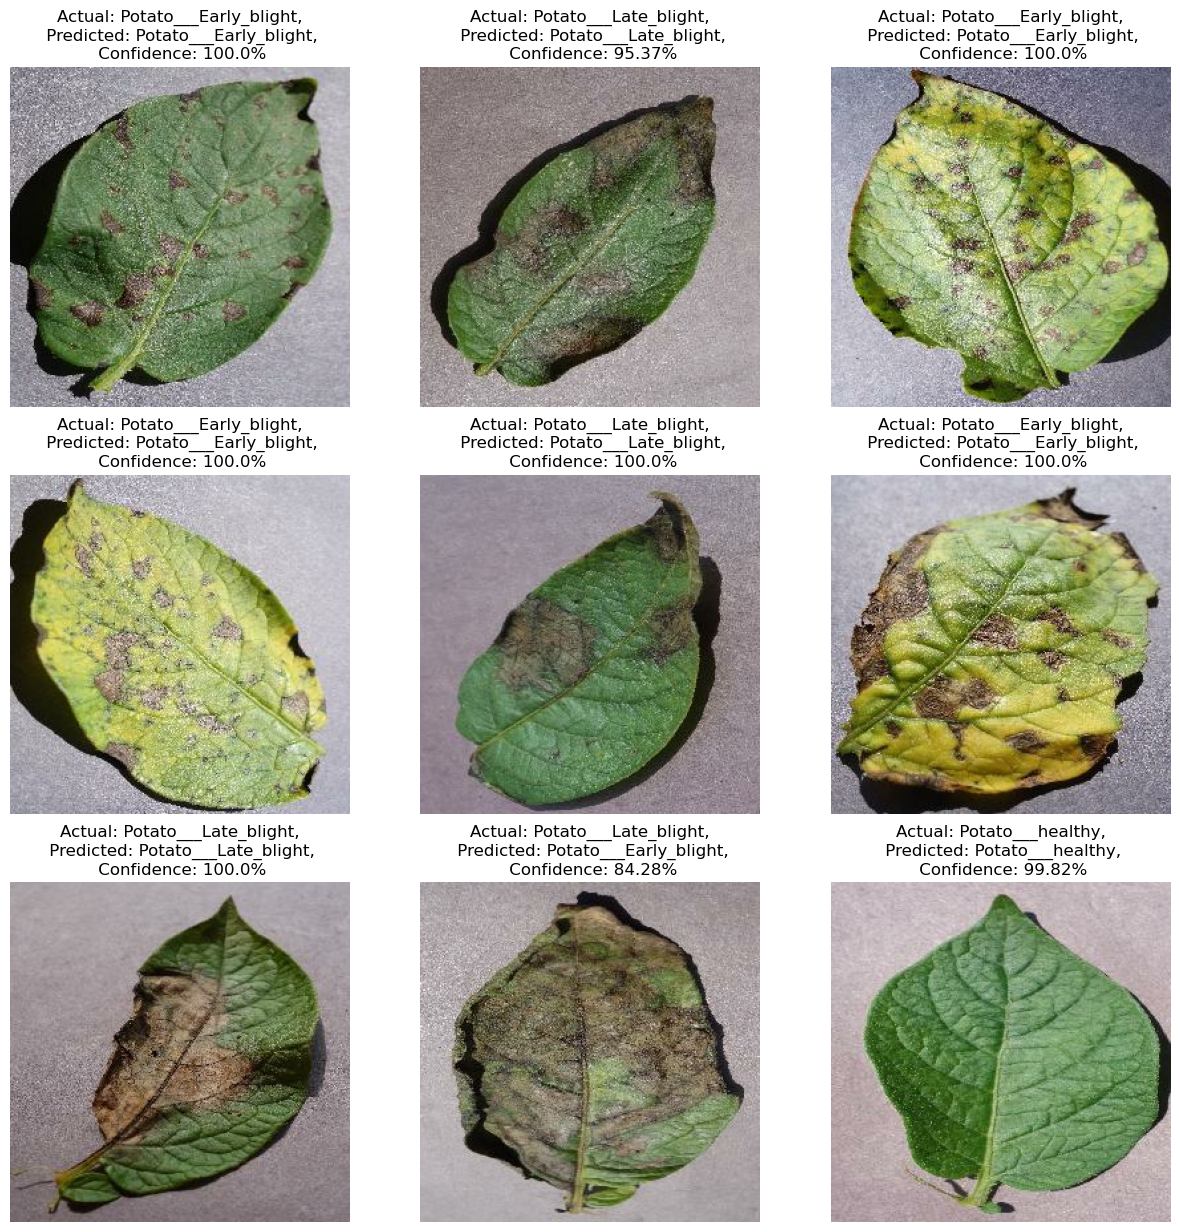

In [76]:
#predict 9 element
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence = predict(model , images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

In [80]:
#saving different model
#import os
#model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
#model.save(f"../models/{model_version}")

In [78]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
